# Data Vault Demo (Quant, can also score own portfolio)

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. Dev engine sees all
    2. **Quant engine can do temp scoring but not see fundamental company info**
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. With Dev engine, construct Vaults for:
    1. Fundamental corporate financial information
    2. Corporate emissions data (base year, historical)
    3. Corporate target data (start year, end year, target start value, target end value)
    4. Sector benchmark data (production, CO2e intensity)
3. Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions
4. **Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores**
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
from dotenv import load_dotenv

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

import trino
from sqlalchemy.engine import create_engine

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

In [2]:
import json
import pandas as pd
from numpy.testing import assert_array_equal
import ITR

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import VaultCompanyDataProvider, VaultProviderProductionBenchmark, \
    VaultProviderIntensityBenchmark, DataVaultWarehouse
# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEIBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/sqlalchemy_trino/dialect.py:259: SAWarning: Dialect trino:rest will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  res = connection.execute(sql.text(query)).scalar()


### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

In [3]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER2'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER2']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev',
    'schema': 'demo_dv',
}

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo_dv'

engine_quant = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_quant))
connection_quant = engine_quant.connect()

connecting with engine Engine(trino://os-climate-user2@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/)


Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

In [4]:
vault_company_data = VaultCompanyDataProvider (engine_quant,
                                               company_table='company_data',
                                               target_table=None,
                                               trajectory_table=None,
                                               company_schema='demo_dv',
                                               column_config=None,
                                               tempscore_config=None)

In [5]:
vault_warehouse = DataVaultWarehouse(engine_quant,
                                     company_data=None,
                                     benchmark_projected_production=None,
                                     benchmarks_projected_ei=None,
                                     ingest_schema = 'demo_dv',
                                     column_config=None,
                                     tempscore_config=None)

vault_warehouse.quant_init(engine_quant, company_data=vault_company_data, ingest_schema='demo_dv')

In [6]:
from ITR.data.osc_units import *
ureg.setup_matplotlib()

In [7]:
# Because this DF comes from reading a Trino table, and because columns must be unqiue, we don't have to enumerate to ensure we properly handle columns with duplicated names

def requantify_df(df: pd.DataFrame) -> pd.DataFrame:
    units_col = None
    columns_reversed = reversed(df.columns)
    for col in columns_reversed:
        if col.endswith("_units"):
            if units_col:
                # We expect _units column to follow a non-units column
                raise ValueError
            units_col = col
            continue
        if units_col:
            if col + '_units' != units_col:
                raise ValueError
            if (df[units_col]==df[units_col][0]).all():
                # Make a PintArray
                new_col = PintArray(df[col], dtype=f"pint[{ureg(df[units_col][0]).u}]")
            else:
                # Make a pd.Series of Quantity in a way that does not throw UnitStrippedWarning
                new_col = pd.Series(data=df[col], name=col) * pd.Series(data=df[units_col].map(lambda x: ureg(x).u), name=col)
            df = df.drop(columns=units_col)
            df[col] = new_col
            units_col = None
    return df

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

In [8]:
sql_temp_score_df = pd.read_sql_table(f"temperature_scores", engine_quant)

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'partition' was not located in columns for table 'temperature_scores'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'record_count' was not located in columns for table 'temperature_scores'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'file_count' was not located in columns for table 'temperature_scores'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'total_size' was not located in columns for table 'temperature_scores'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'data' was not located in columns for table 'temperature_scores'
  tbl = Ta

In [9]:
temp_score_df = requantify_df(sql_temp_score_df)
temp_score_df.trajectory_temperature_score = temp_score_df.trajectory_temperature_score.astype('pint[delta_degC]')
temp_score_df.target_temperature_score = temp_score_df.target_temperature_score.astype('pint[delta_degC]')

In [10]:
plottable_df = temp_score_df[['company_name', 'trajectory_temperature_score', 'target_temperature_score']].sort_values('company_name').set_index('company_name').T

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


<AxesSubplot:>

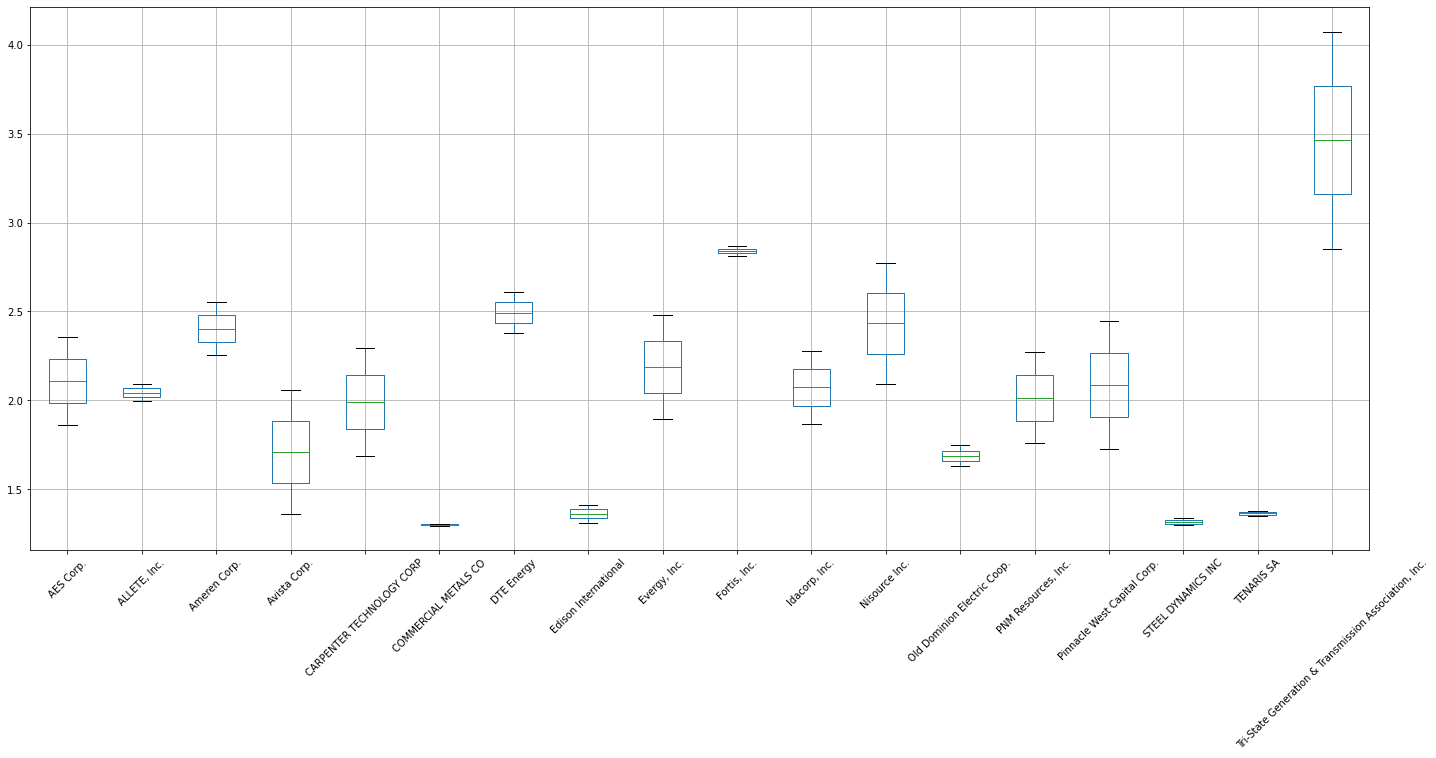

In [11]:
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.applymap(lambda x: x.m).iloc[:, [x for x in list(range(0,2)) + list(range(4,52,3))]].boxplot(figsize=(24,10), rot=45)

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *can also* access both cumulative emissions (input) and temperature scores (output)

In [12]:
portfolio_df = pd.read_csv("data/mdt-20220116-portfolio.csv", encoding="iso-8859-1", sep=';', index_col='company_id')
portfolio_df

,company_name,company_lei,investment_value
company_id,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812
...,...,...,...
US8873991033,TIMKENSTEEL CORP,549300QZTZWHDE9HJL14,10000000
US88830M1027,TITAN INTERNATIONAL INC,254900CXRGBE7C4B5A06,10000000
US9129091081,UNITED STATES STEEL CORP,JNLUVFYJT1OZSIQ24U47,10000000


### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

In [13]:
# PA_SCORE means "Probability-Adjusted" Temperature Score
portfolio_df['pa_score'] = vault_warehouse.get_pa_temp_scores(probability=0.5, company_ids=portfolio_df.index.values).astype('pint[delta_degC]')

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


In [14]:
# portfolio_df[portfolio_df.company_name=='POSCO']
portfolio_df.dropna(inplace=True)
portfolio_df.sort_values(by='company_name')

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


,company_name,company_lei,investment_value,pa_score
company_id,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.106926870694208
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.043793289146705
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.2623320662937099
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.867044766546712
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.404261301598871
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,45520637,2.1814181749376793
US05351W1036,"Avangrid, Inc.",549300OX0Q38NLSKPB49,10049068,1.624145450892199
US05379B1070,Avista Corp.,Q0IK63NITJD6RJ47SW96,2804211,1.7099274356102043
US1442851036,CARPENTER TECHNOLOGY CORP,DX6I6ZD3X5WNNCDJKP85,10000000,1.9900906690954119


In [15]:
weight_for_WATS = portfolio_df['investment_value'].sum()
weight_for_WATS

659616728

In [16]:
portfolio_df['WATS_weight'] = portfolio_df['pa_score'] * (portfolio_df['investment_value'] / weight_for_WATS)
portfolio_df.head()

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


,company_name,company_lei,investment_value,pa_score,WATS_weight
company_id,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.106926870694208,0.013898631388198987
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.2623320662937099,0.004264157132071172
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.043793289146705,0.011865477687998862
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.867044766546712,0.010839343752422344
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.404261301598871,0.058019419115953846


In [17]:
print(f"Portfolio temperature score based on WATS = {portfolio_df['WATS_weight'].sum()}")

Portfolio temperature score based on WATS = 1.946471711490046 delta_degree_Celsius


### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

In [18]:
portfolio_df['TETS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'emissions', EScope.S1S2).astype('pint[delta_degC]')
portfolio_df.head()

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight
company_id,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.106926870694208,0.013898631388198987,1.4900271821443577e-07
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.2623320662937099,0.004264157132071172,4.162829462365117e-12
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.043793289146705,0.011865477687998862,5.2549678751293906e-08
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.867044766546712,0.010839343752422344,1.261547907437679e-07
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.404261301598871,0.058019419115953846,3.4265102068870053e-07


In [19]:
print(f"Portfolio temperature score based on TETS = {portfolio_df['TETS_weight'].sum()}")

Portfolio temperature score based on TETS = 1.5060118497978 delta_degree_Celsius


### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

In [20]:
portfolio_df.dtypes

company_name                            object
company_lei                             object
investment_value                         int64
pa_score            pint[delta_degree_Celsius]
WATS_weight         pint[delta_degree_Celsius]
TETS_weight         pint[delta_degree_Celsius]
dtype: object

In [21]:
weighting_dict = {
    'MOTS': 'company_market_cap',
    'EOTS': 'company_ev',
    'ECOTS': 'company_evic',
    'AOTS': 'company_total_assets',
    'ROTS': 'company_revenue',
}

for k, v in weighting_dict.items():
    weight_column = f"{k}_weight"
    portfolio_df[weight_column] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, v, EScope.S1S2)
    print(f"Portfolio temperature score based on {k} = {portfolio_df[weight_column].sum()}")

portfolio_df

Portfolio temperature score based on MOTS = 1.998539728638169 delta_degree_Celsius
Portfolio temperature score based on EOTS = 1.9715101533914599 delta_degree_Celsius
Portfolio temperature score based on ECOTS = 1.9914244268264996 delta_degree_Celsius
Portfolio temperature score based on AOTS = 1.9769581669116627 delta_degree_Celsius
Portfolio temperature score based on ROTS = 1.8572293378229632 delta_degree_Celsius


/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.106926870694208,0.013898631388198987,1.4900271821443577e-07,0.03357412161990311,0.020337868906115608,0.03667288993043838,0.04816939688533329,0.05276197099873813
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,1.2623320662937099,0.004264157132071172,4.162829462365117e-12,nan,nan,nan,0.009358782813005341,0.0050413384247108275
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.043793289146705,0.011865477687998862,5.2549678751293906e-08,0.012839373901951686,0.011385162596862225,0.013018784526381704,0.007613807008198652,0.006231229172975224
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,1.867044766546712,0.010839343752422344,1.261547907437679e-07,0.03174960844912046,0.0330110683879106,0.03172544768591218,0.021186142904952205,0.016738395724396053
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.404261301598871,0.058019419115953846,3.4265102068870053e-07,0.06477745482537144,0.06387775855844924,0.06469360527719219,0.04726477824338227,0.034922806188620925
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,45520637,2.1814181749376793,0.15054127748946447,7.719971932013753e-07,0.139082507959553,0.15303279317063806,0.13956919099354945,0.11248617091168711,0.08343102518455157
US05351W1036,"Avangrid, Inc.",549300OX0Q38NLSKPB49,10049068,1.624145450892199,0.024743381095553976,2.5939403676600244e-10,0.00675237883315782,0.016801248692288422,0.007160665331019981,0.0379793742030801,0.02529980312047131
US05379B1070,Avista Corp.,Q0IK63NITJD6RJ47SW96,2804211,1.7099274356102043,0.0072693688934764664,2.5464088060658733e-08,0.007391183784912206,0.008035321000941292,0.007399948532530545,0.007066740568098292,0.005655105952879468
US18551QAA58,Cleco Partners LP,5493002H80P81B3HXL31,3086052,2.280309768660802,0.01066855072571053,1.1727968749659209e-07,nan,nan,nan,0.011583583746330367,0.009189101919284608


### Companies for which we lack production data (and thus cannot chart)

In [22]:
portfolio_df[portfolio_df.pa_score.isnull()]

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,


In [23]:
engine_quant.execute("select * from demo_dv.company_data").fetchall()

[('AES Corp.', '2NUNNB7D43COUIRE5295', 'US00130H1059', 'Electricity Utilities', 'US', 'North America', 'equity', 'USD', 2019, 10870000000.0, 10189000000.0, 10102000000, 11131000000.0, 33648000000.0, 1029000000.0, 261000000.0),
 ('ALLETE, Inc.', '549300NNLSIMY6Z8OT86', 'US0185223007', 'Electricity Utilities', 'US', 'North America', 'equity', 'USD', 2019, 4285299935.0, 1240500000.0, 5829799935, 5899099935.0, 5482800000.0, 69300000.0, 1613800000.0),
 ('Algonquin Power & Utilities Corp.', '549300K5VIUTJXQL7X75', 'US0158577090', 'Electricity Utilities', 'CA', 'North America', 'equity', 'USD', 2019, None, 1624921000.0, None, None, 10911470000.0, 62485000.0, 6500799000.0),
 ('Alliant Energy', '5493009ML300G373MZ12', 'US0188021085', 'Electricity Utilities', 'US', 'North America', 'equity', 'USD', 2019, 11600000000.0, 3647700000.0, 18503600000, 18519900000.0, 16700700000.0, 16300000.0, 6919900000.0),
 ('Ameren Corp.', 'XRZQ5S7HYJFPHJ78L959', 'US0236081024', 'Electricity Utilities', 'US', 'North